### 1. Import Libraries

In [1]:
!pip install yellowbrick

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer


### 2. Data Cleaning

In [141]:
df=pd.read_csv('marketing_campaign.csv',sep="\t")

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

we can see there is null value in "income" and Dt_customer is not date type.

In [143]:
df.duplicated().sum()

0

In [144]:
df.skew()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33324\1665899112.py:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.skew()


ID                      0.039832
Year_Birth             -0.349944
Income                  6.763487
Kidhome                 0.635288
Teenhome                0.407115
Recency                -0.001987
MntWines                1.175771
MntFruits               2.102063
MntMeatProducts         2.083233
MntFishProducts         1.919769
MntSweetProducts        2.136081
MntGoldProds            1.886106
NumDealsPurchases       2.418569
NumWebPurchases         1.382794
NumCatalogPurchases     1.880989
NumStorePurchases       0.702237
NumWebVisitsMonth       0.207926
AcceptedCmp3            3.291705
AcceptedCmp4            3.241574
AcceptedCmp5            3.291705
AcceptedCmp1            3.555444
AcceptedCmp2            8.472093
Complain               10.188972
Z_CostContact           0.000000
Z_Revenue               0.000000
Response                1.971555
dtype: float64

#### 2.1 Change data type and Fill null value

In [145]:
##data type change
df['Dt_Customer']=pd.to_datetime(df['Dt_Customer'])

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33324\4177086434.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Dt_Customer']=pd.to_datetime(df['Dt_Customer'])


In [146]:
#drop NA
df=df.dropna()

#### 2.2 Feature Engineering

In [147]:
df['ID'].duplicated().any()
#so there is no duplicated id in this table

False

In [148]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [149]:
df['Education'].value_counts()

Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64

In [150]:
#Age of customer
latest_date=max(df['Dt_Customer'])
df['Age']=latest_date.year-df['Year_Birth']

#education
df['Education'] = df['Education'].replace(['Basic', '2n Cycle'],'Undergraduate')
df['Education'] = df['Education'].replace(['Master', 'PhD'],'Postgraduate')
df['Education'] = df['Education'].replace(['Graduation'],'Graduate')

# Marital_Status
df['Marital_Status'] = df['Marital_Status'].replace(['Married', 'Together'],'Pair')
df['Marital_Status'] = df['Marital_Status'].replace(['Divorced', 'Widow', 'Alone', 'YOLO', 'Absurd'],'Single')

#Children number
df['Children_num'] = df['Kidhome']+df['Teenhome']
df['Is_parents']=np.where(df.Children_num>0,1,0)

df['Adult_num']=np.where(df.Marital_Status=='Single',1,2)
df['Family_size']=df['Children_num']+df['Adult_num']

#define the total days customer 
df['retain_days']=(latest_date-df['Dt_Customer']).dt.days

#total spending on items and rename
df['Total_spent']=df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df=df.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#total Accepted cmp
df['TotalAcceptedCmp'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']

#total purchase number and rename purchase channel
df['NumTotalPurchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] + df['NumDealsPurchases']



In [151]:
#drop useless columns
df = df.drop(columns=["Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth","Kidhome", "Teenhome",'Adult_num'], axis=1)

#### 2.3 Delete outliers

In [152]:
df.describe()

ID         Income      Recency        Wines       Fruits  \
count   2216.000000    2216.000000  2216.000000  2216.000000  2216.000000   
mean    5588.353339   52247.251354    49.012635   305.091606    26.356047   
std     3249.376275   25173.076661    28.948352   337.327920    39.793917   
min        0.000000    1730.000000     0.000000     0.000000     0.000000   
25%     2814.750000   35303.000000    24.000000    24.000000     2.000000   
50%     5458.500000   51381.500000    49.000000   174.500000     8.000000   
75%     8421.750000   68522.000000    74.000000   505.000000    33.000000   
max    11191.000000  666666.000000    99.000000  1493.000000   199.000000   

              Meat         Fish       Sweets         Gold  NumDealsPurchases  \
count  2216.000000  2216.000000  2216.000000  2216.000000        2216.000000   
mean    166.995939    37.637635    27.028881    43.965253           2.323556   
std     224.283273    54.752082    41.072046    51.815414           1.923716   
min       0.000000     0.000000     0.000000     0.000000           0.000000   
25%      16.000000     3.000000     1.000000     9.000000           1.000000   
50%      68.000000    12.000000     8.000000    24.500000           2.000000   
75%     232.250000    50.000000    33.000000    56.000000           3.000000   
max    1725.000000   259.000000   262.000000   321.000000          15.000000   

       ...     Complain     Response          Age  Children_num   Is_parents  \
count  ...  2216.000000  2216.000000  2216.000000   2216.000000  2216.000000   
mean   ...     0.009477     0.150271    45.179603      0.947202     0.714350   
std    ...     0.096907     0.357417    11.985554      0.749062     0.451825   
min    ...     0.000000     0.000000    18.000000      0.000000     0.000000   
25%    ...     0.000000     0.000000    37.000000      0.000000     0.000000   
50%    ...     0.000000     0.000000    44.000000      1.000000     1.000000   
75%    ...     0.000000     0.000000    55.000000      1.000000     1.000000   
max    ...     1.000000     1.000000   121.000000      3.000000     1.000000   

       Family_size  retain_days  Total_spent  TotalAcceptedCmp  \
count  2216.000000  2216.000000  2216.000000       2216.000000   
mean      2.592509   512.006318   607.075361          0.298285   
std       0.905722   232.469034   602.900476          0.679209   
min       1.000000     0.000000     5.000000          0.000000   
25%       2.000000   340.000000    69.000000          0.000000   
50%       3.000000   513.000000   396.500000          0.000000   
75%       3.000000   686.000000  1048.000000          0.000000   
max       5.000000  1063.000000  2525.000000          4.000000   

       NumTotalPurchases  
count        2216.000000  
mean           14.880866  
std             7.670957  
min             0.000000  
25%             8.000000  
50%            15.000000  
75%            21.000000  
max            44.000000  

[8 rows x 29 columns]

Text(0.5, 1.0, 'Revenue distribution')

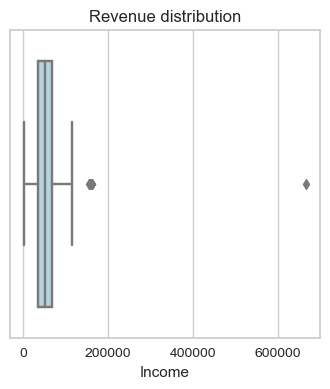

In [153]:
plt.figure(figsize=(4, 4))
sns.boxplot(x=df['Income'], color='lightblue')
plt.title('Revenue distribution')


Text(0.5, 1.0, 'Age distribution')

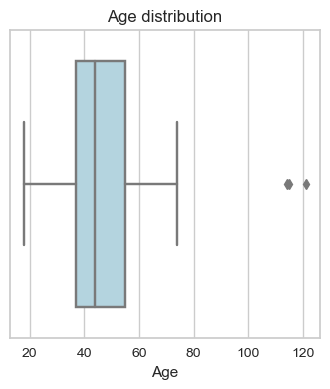

In [16]:
plt.figure(figsize=(4, 4))
sns.boxplot(x=df['Age'], color='lightblue')
plt.title('Age distribution')

In [154]:
#drop outliers
df=df[df['Income'] < 600000]
df=df[df['Age']<90]

### 3. Correlation

<Figure size 1000x800 with 0 Axes>

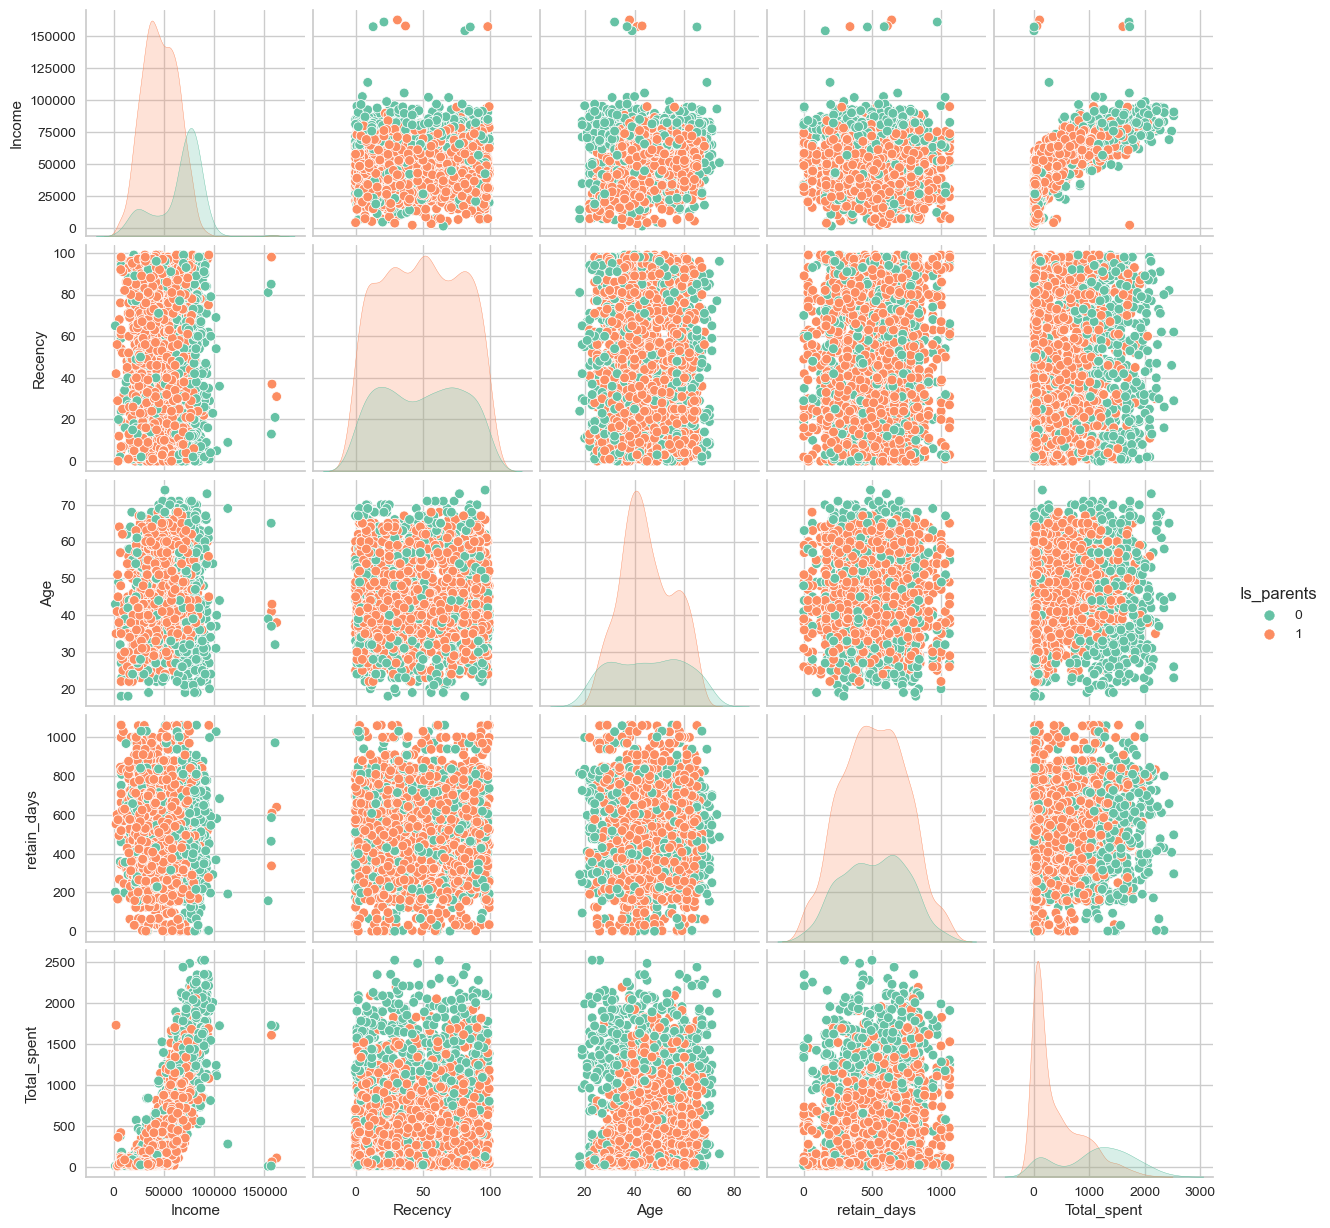

In [18]:
plt.figure(figsize=(10,8))
sns.pairplot(df[['Income', 'Recency', 'Age', 'retain_days', 'Total_spent','Is_parents']], hue='Is_parents', palette='Set2')
plt.show()

In [19]:
df.columns

Index(['ID', 'Education', 'Marital_Status', 'Income', 'Recency', 'Wines',
       'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Age',
       'Children_num', 'Is_parents', 'Family_size', 'retain_days',
       'Total_spent', 'TotalAcceptedCmp', 'NumTotalPurchases'],
      dtype='object')

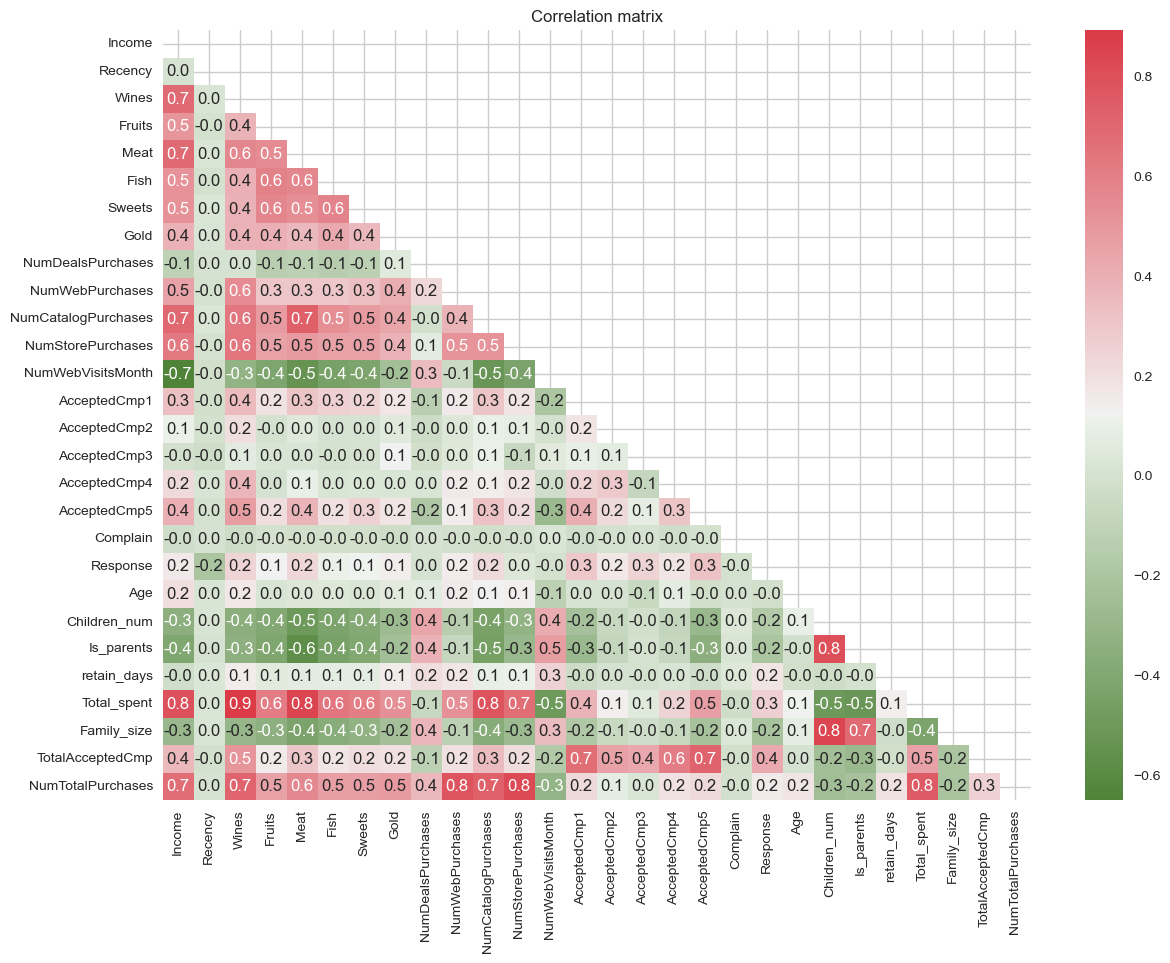

In [20]:
#Matrix
to_corr = ['Income', 'Recency', 'Wines', 'Fruits',
       'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp1', 'AcceptedCmp2','AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5','Complain', 'Response', 'Age',
       'Children_num', 'Is_parents', 'retain_days', 'Total_spent',
       'Family_size','TotalAcceptedCmp', 'NumTotalPurchases']

cmap = sns.diverging_palette(120, 10, as_cmap=True)
matrix = np.triu(df[to_corr].corr())
plt.figure(figsize=(14, 10))
plt.title('Correlation matrix', fontsize=12)
sns.heatmap(df[to_corr].corr(), annot=True,
            fmt='.1f', cmap=cmap, mask=matrix)

plt.show()

### 4. Data Pre-process

#### 4.1 make all variable numerical

In [155]:
#Make all variable be numerical
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical variables in the dataset:", categorical_cols)

label_encoder = LabelEncoder()

for col in categorical_cols:
    try:
        df[col] = label_encoder.fit_transform(df[col])
    except Exception as e:
        print(f"Error encoding {col}: {e}")

print("All features are now numerical")

Categorical variables in the dataset: ['Education', 'Marital_Status']
All features are now numerical


In [71]:
df2=df.copy()

In [72]:
df2=df2.drop(columns=['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','AcceptedCmp1', 'AcceptedCmp2','Complain', 'Response','TotalAcceptedCmp','NumTotalPurchases','ID'])

In [73]:
df2.columns

Index(['Education', 'Marital_Status', 'Income', 'Recency', 'Wines', 'Fruits',
       'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Age', 'Children_num', 'Is_parents', 'Family_size',
       'retain_days', 'Total_spent'],
      dtype='object')

#### 4.2 standardize the variable

In [90]:
#Standardize all the variable
scaler=StandardScaler()
continuous_vars = ['Income', 'Recency', 'Wines', 'Fruits',
       'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Age', 'Children_num','Family_size',
       'retain_days', 'Total_spent']
df2[continuous_vars] = scaler.fit_transform(df2[continuous_vars])
print('standardized finished')

standardized finished


#### 4.3 PCA components

4.3.1 select suitable PC number

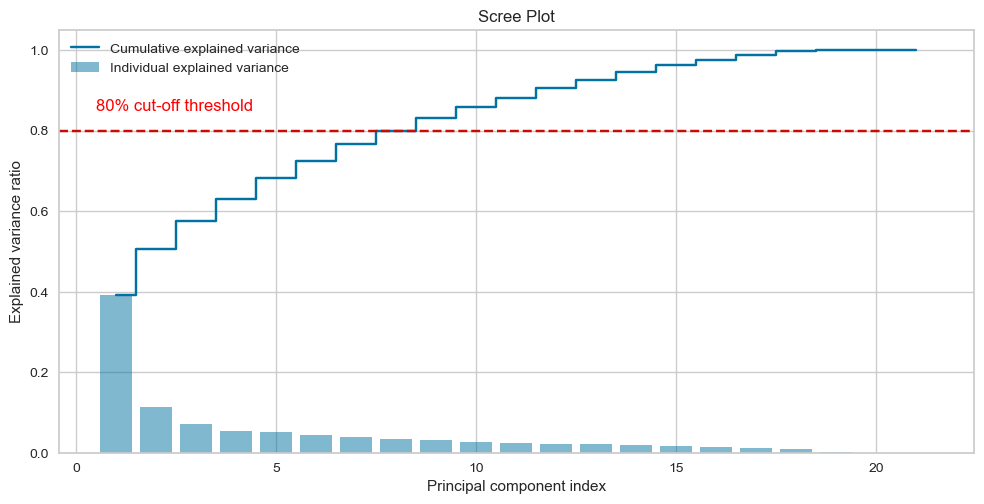

In [91]:
pca = PCA()
pca.fit(df2)

explained_variance_ratio = pca.explained_variance_ratio_

#Calculate cumulative variance explained
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

#plot
plt.figure(figsize=(10, 5))

plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center',
        label='Individual explained variance')

plt.step(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, where='mid',
         label='Cumulative explained variance')

plt.axhline(y=0.8, color='r', linestyle='--')  # 80% variance explained line
plt.text(0.5, 0.85, '80% cut-off threshold', color = "red", fontsize=12)

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.title('Scree Plot')
plt.show()


So we select 8 as principal component number

In [92]:
pca = PCA(n_components=8)
pca.fit(df2)
pca_df = pd.DataFrame(pca.transform(df2),columns=(["pc1","pc2", "pc3","pc4","pc5","pc6", "pc7","pc8"]))
pca_df.describe().T

count          mean       std       min       25%       50%       75%  \
pc1  2212.0  1.413376e-16  2.719877 -5.668907 -2.402290 -0.825043  2.340486   
pc2  2212.0  1.284887e-17  1.465612 -3.726840 -1.077985 -0.187536  0.949001   
pc3  2212.0 -1.766720e-17  1.160817 -3.653060 -0.793054 -0.022546  0.765490   
pc4  2212.0  2.168247e-17  1.006115 -2.693055 -0.785247 -0.007342  0.796401   
pc5  2212.0  8.833601e-18  0.995852 -3.354048 -0.606230 -0.035033  0.646484   
pc6  2212.0  2.730386e-17  0.907621 -3.109223 -0.567006  0.025562  0.566361   
pc7  2212.0 -9.636656e-18  0.870180 -5.611280 -0.519356  0.006233  0.551540   
pc8  2212.0 -3.212219e-18  0.800178 -4.902170 -0.348196 -0.036287  0.295361   

          max  
pc1  7.351913  
pc2  6.133008  
pc3  5.835889  
pc4  2.712433  
pc5  3.443995  
pc6  4.681307  
pc7  6.215372  
pc8  7.168105

### 5. Four Different Clustering Model

#### 5.1 K-Means

d:\ECA5307\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\ECA5307\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
d:\ECA5307\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\ECA5307\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
d:\ECA53

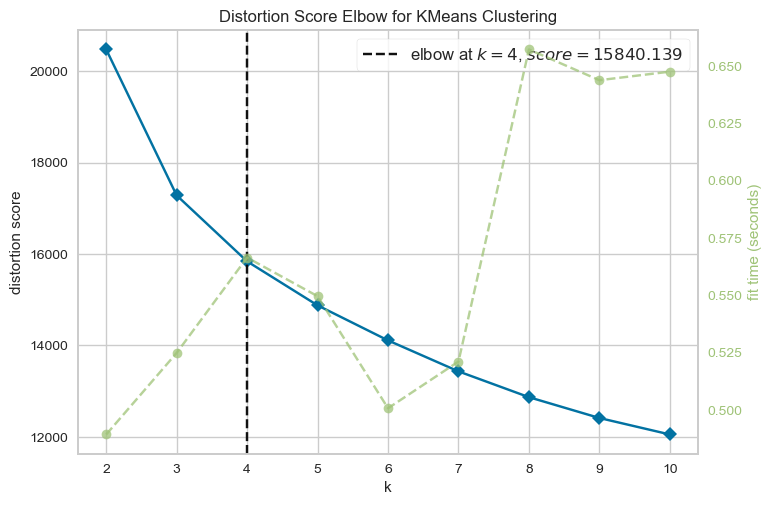

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [93]:
#Select Cluster center point
model = KMeans()
visualizer = KElbowVisualizer(model, k=10)
visualizer.fit(pca_df) # Fit the data to the visualizer
visualizer.show() 
#use distortion as evaluation principle

In [29]:
#best center number = 4

d:\ECA5307\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\ECA5307\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.19113517969003538


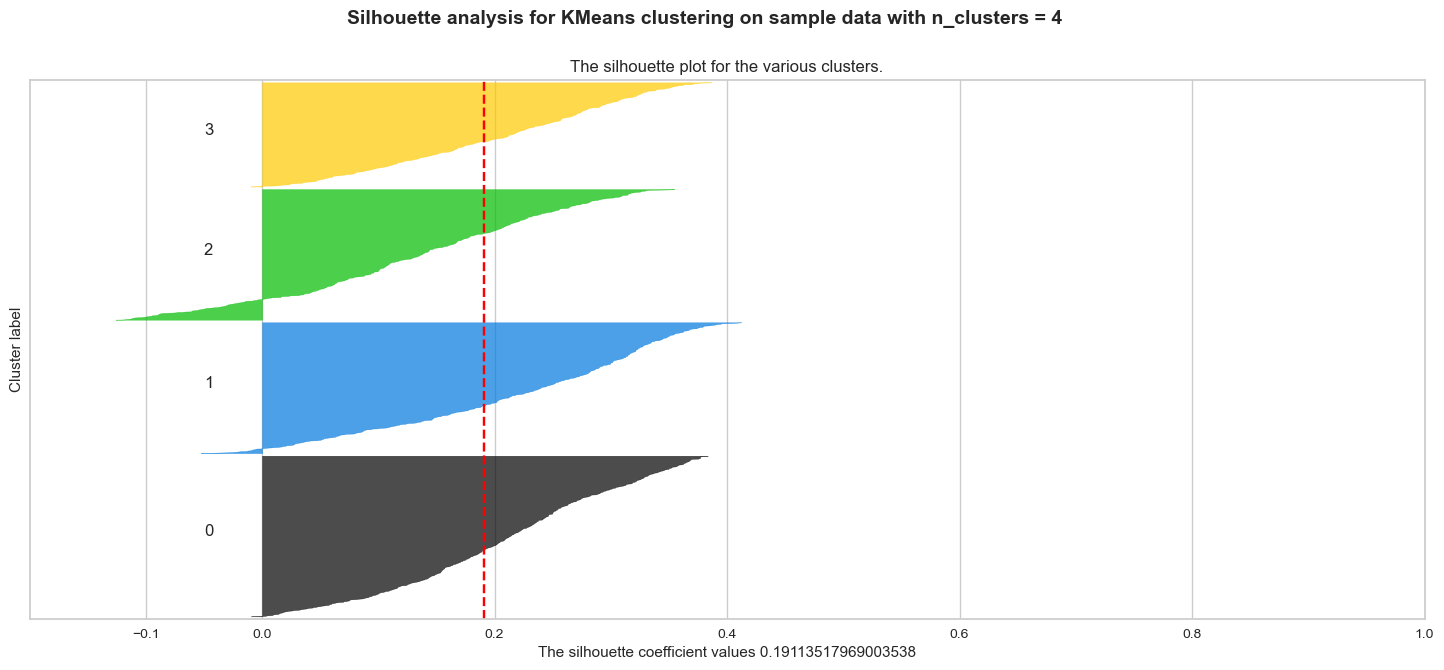

In [94]:
n_clusters = 4

# create subplot with 1 row and 1 column
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

# silhouette coefficient range is [-1, 1]
ax1.set_xlim([-0.2, 1])
ax1.set_ylim([0, len(pca_df) + (n_clusters + 1) * 10])#10 is space between different cluster

# k-means cluster
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
K_cluster_labels = clusterer.fit_predict(pca_df)

#Calculate the silhouette score
silhouette_avg = silhouette_score(pca_df, K_cluster_labels)
print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)

# calculate every samples' silhouette value
sample_silhouette_values = silhouette_samples(pca_df, K_cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # group silhouette value by cluster label，and then sort in group from small to big
    ith_cluster_silhouette_values = sample_silhouette_values[K_cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # give label of every K-means cluster label
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # calculate y_lower start point for next cluster 
    y_lower = y_upper + 10  # 10 is the space

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel(f"The silhouette coefficient values {silhouette_avg}")
ax1.set_ylabel("Cluster label")

# show silhouette average value
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # clear y-label
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# show the plot
plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = %d" % n_clusters),
             fontsize=14, fontweight='bold')

plt.show()



#### 5.2 Agglomerative Clustering

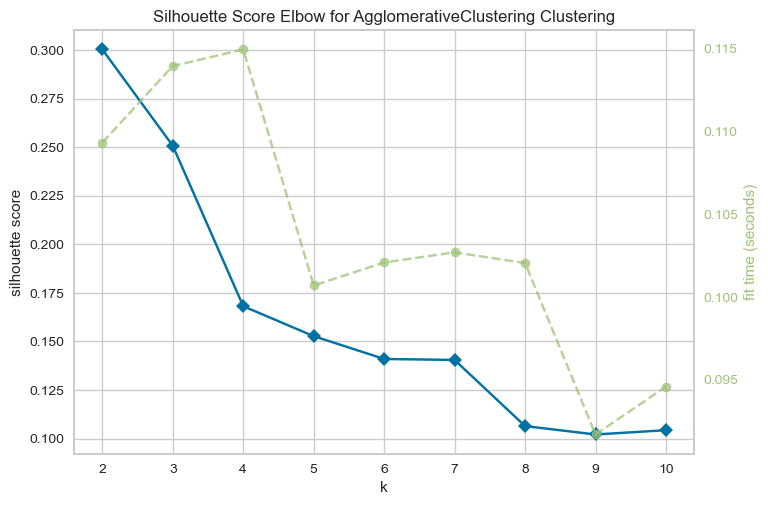

<Axes: title={'center': 'Silhouette Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='silhouette score'>

In [95]:
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=10, metric='silhouette',locate_elbow=False)
visualizer.fit(pca_df) # Fit the data to the visualizer
visualizer.show() 

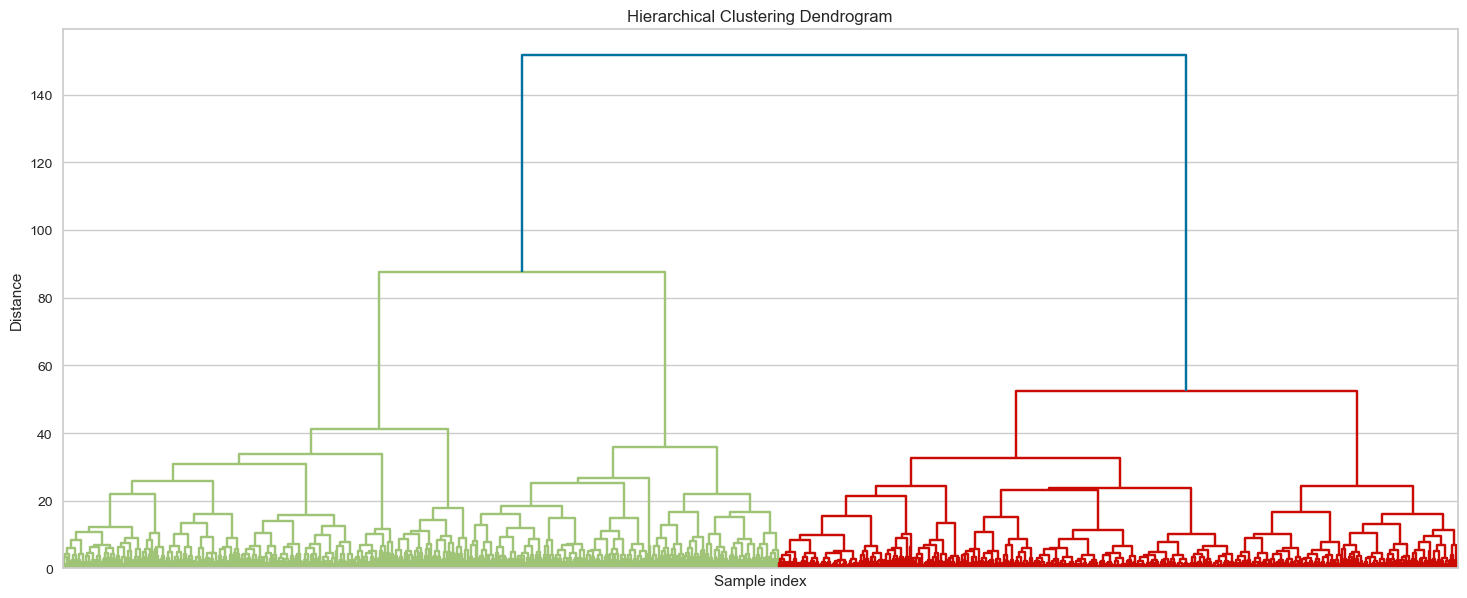

According to the tree structure, we can decide the cluster number is 3


In [96]:
#Use Dendrogram to choose cluster number
# 'ward' is a minimising merge strategy using the sum of squares of distances, also 'single', 'complete', 'average'
linked = linkage(pca_df, method='ward')

# plot tree
plt.figure(figsize=(18, 7))
dendrogram(linked,
           orientation='top',
           labels=pca_df.index,
           distance_sort='descending',
           show_leaf_counts=False,
            no_labels=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

print("According to the tree structure, we can decide the cluster number is 3")

For n_clusters = 3 The average silhouette_score is : 0.25074052251248613


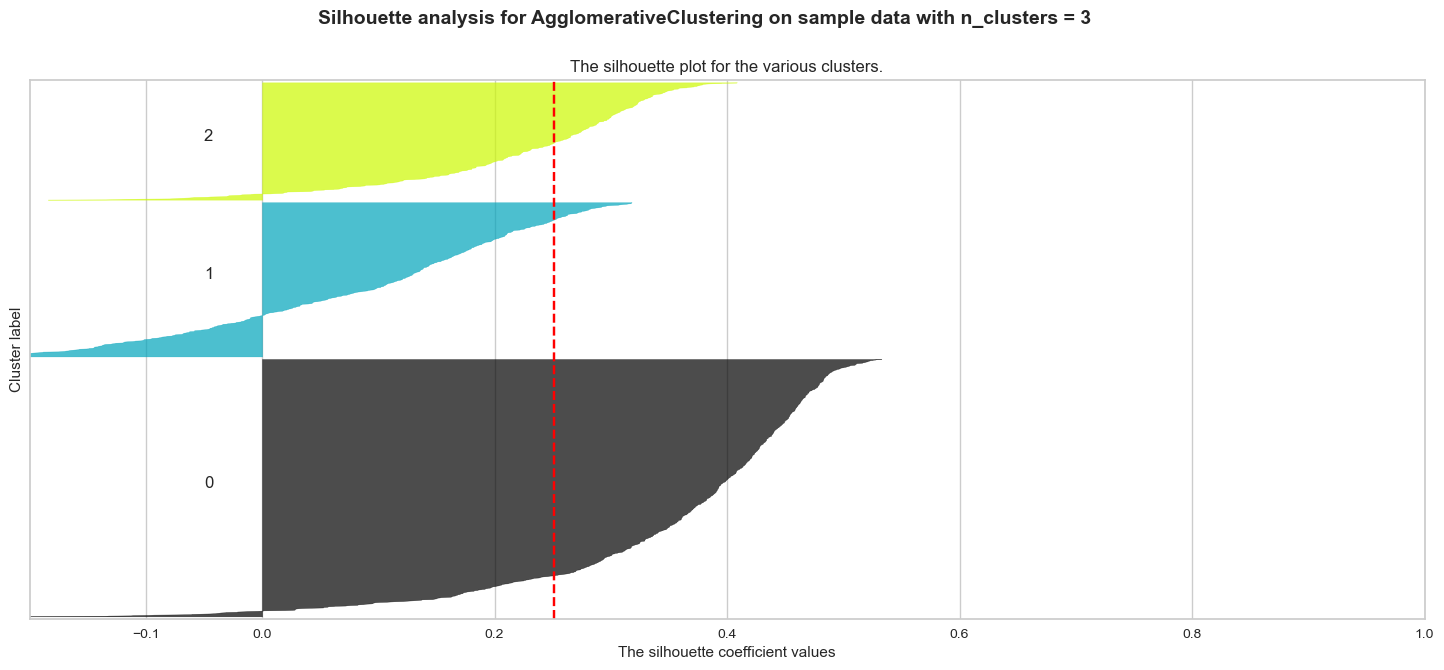

In [97]:
#fit the Agglomerative Clustering Model
n_clusters = 3

# create subplot with 1 row and 1 column
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

# silhouette coefficient range is [-1, 1]
ax1.set_xlim([-0.2, 1])
ax1.set_ylim([0, len(pca_df) + (n_clusters + 1) * 10])#10 is space between different cluster

# Agglomerative cluster
clusterer2 = AgglomerativeClustering(n_clusters=n_clusters)
A_cluster_labels = clusterer2.fit_predict(pca_df)

#Calculate the silhouette score
silhouette_avg = silhouette_score(pca_df, A_cluster_labels)
print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)

# calculate every samples' silhouette value
sample_silhouette_values = silhouette_samples(pca_df, A_cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # group silhouette value by cluster label，and then sort in group from small to big
    ith_cluster_silhouette_values = sample_silhouette_values[A_cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # give label of every K-means cluster label
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # calculate y_lower start point for next cluster 
    y_lower = y_upper + 10  # 10 is the space

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# show silhouette average value
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # clear y-label
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# show the plot
plt.suptitle(("Silhouette analysis for AgglomerativeClustering on sample data "
              "with n_clusters = %d" % n_clusters),
             fontsize=14, fontweight='bold')

plt.show()

#### 5.3 Spectral Cluster

d:\ECA5307\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
d:\ECA5307\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
d:\ECA5307\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
d:\ECA5307\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

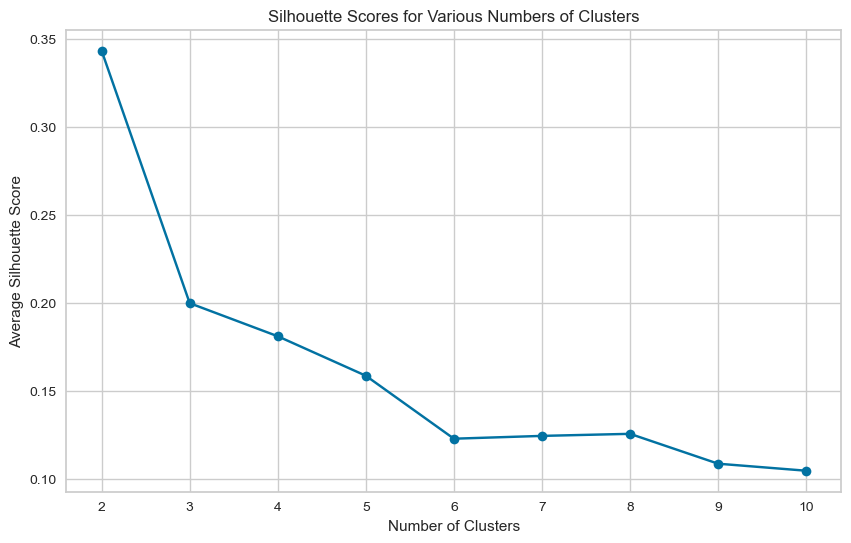

In [33]:
# Set the range of clusters to try
range_n_clusters = range(2, 11)

# List to store the average silhouette scores for each n_clusters
silhouette_avg_scores = []

# Perform Spectral Clustering with varying number of clusters
for n_clusters in range_n_clusters:
    # Create a Spectral Clustering model
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors')
    
    # Fit and predict to classify data into clusters
    cluster_labels = spectral.fit_predict(pca_df)
    
    # Calculate the average silhouette score and append it to the list
    silhouette_avg = silhouette_score(pca_df, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Scores for Various Numbers of Clusters')
plt.show()


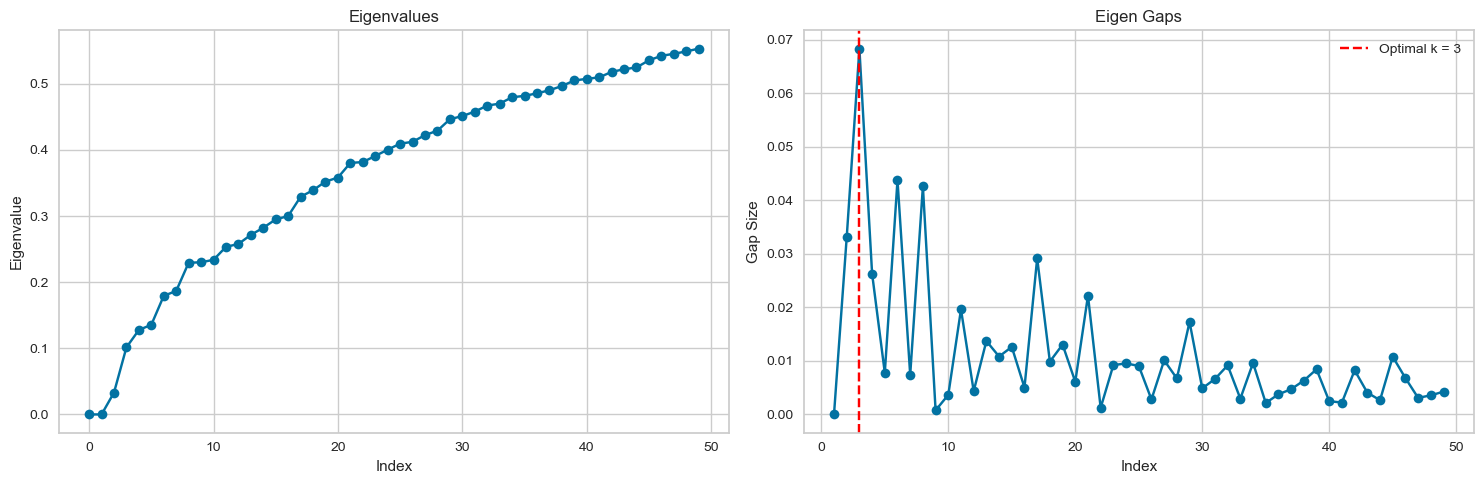

The optimal number of clusters (k) is: 3


In [34]:
from sklearn.metrics import pairwise_distances
from scipy.sparse.csgraph import laplacian as csgraph_laplacian
from scipy.linalg import eigh
import numpy as np
import matplotlib.pyplot as plt

# Compute the similarity or affinity matrix
global_std = pca_df.values.std()

similarity_matrix = np.exp(-pairwise_distances(pca_df)**2 / global_std**2)

# Compute the normalized Laplacian matrix
laplacian, dd = csgraph_laplacian(similarity_matrix, normed=True, return_diag=True)

# You should choose a number that's more reasonable, e.g., up to 20 or 50.
# Computing more than that is often unnecessary and computationally intensive.
num_eigenvalues = 50  # Or however many you deem appropriate for your dataset
eigenvalues, eigenvectors = eigh(laplacian, subset_by_index=[0, num_eigenvalues - 1])

# Identify the largest gap in the sorted eigenvalues
eigen_gaps = np.diff(eigenvalues)
max_gap_index = np.argmax(eigen_gaps)
optimal_k = max_gap_index + 1  # This assumes the largest gap dictates the optimal number of clusters

# Plot the sorted eigenvalues and eigen gaps
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(eigenvalues, 'o-')
plt.title('Eigenvalues')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, num_eigenvalues), eigen_gaps, 'o-')
plt.title('Eigen Gaps')
plt.xlabel('Index')
plt.ylabel('Gap Size')
plt.axvline(optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"The optimal number of clusters (k) is: {optimal_k}")

d:\ECA5307\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


The average silhouette_score is : 0.1998957196834816


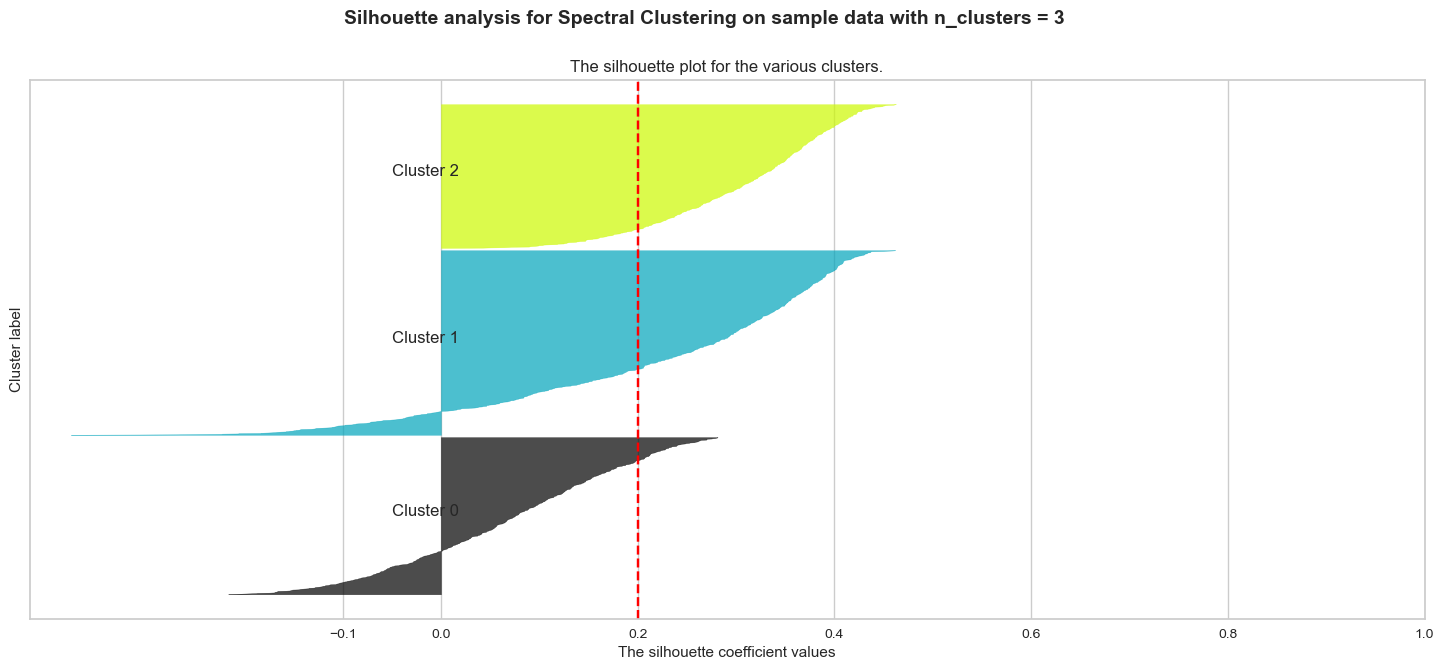

the average silhouette value is 0.1998957196834816


In [35]:
# Spectral Clustering
n_clusters = 3

spectral_model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors')
S_cluster_labels = spectral_model.fit_predict(pca_df)

silhouette_avg = silhouette_score(pca_df, S_cluster_labels)
print(f'The average silhouette_score is : {silhouette_avg}')

sample_silhouette_values = silhouette_samples(pca_df, S_cluster_labels)

fig, ax1 = plt.subplots(1)
fig.set_size_inches(18, 7)

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[S_cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
    y_lower = y_upper + 10 

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(("Silhouette analysis for Spectral Clustering on sample data "
              f"with n_clusters = {n_clusters}"),
             fontsize=14, fontweight='bold')

plt.show()
print(f"the average silhouette value is {silhouette_avg}")

#### 5.4 DBSCAN

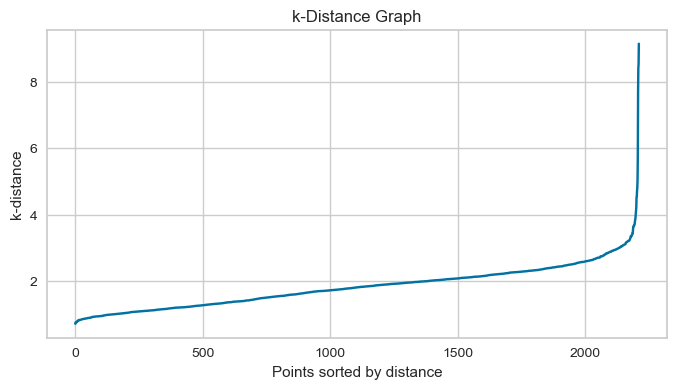

In [36]:
#min sample is twice of dimension
#so we assume min_sample = 2*8=16
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=15)  # use min_samples value
neighbors_fit = neighbors.fit(pca_df)
distances, indices = neighbors_fit.kneighbors(pca_df)

# sort the distance
distances = np.sort(distances, axis=0)
distances = distances[:, 14] 

# plot the distance
plt.figure(figsize=(8,4))
plt.plot(distances)
#plt.axhline(y=3, color='r', linestyle='--')
#plt.text(1, 3.1, 'distance=3', color = "red", fontsize=12)
plt.title('k-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance')
plt.show()



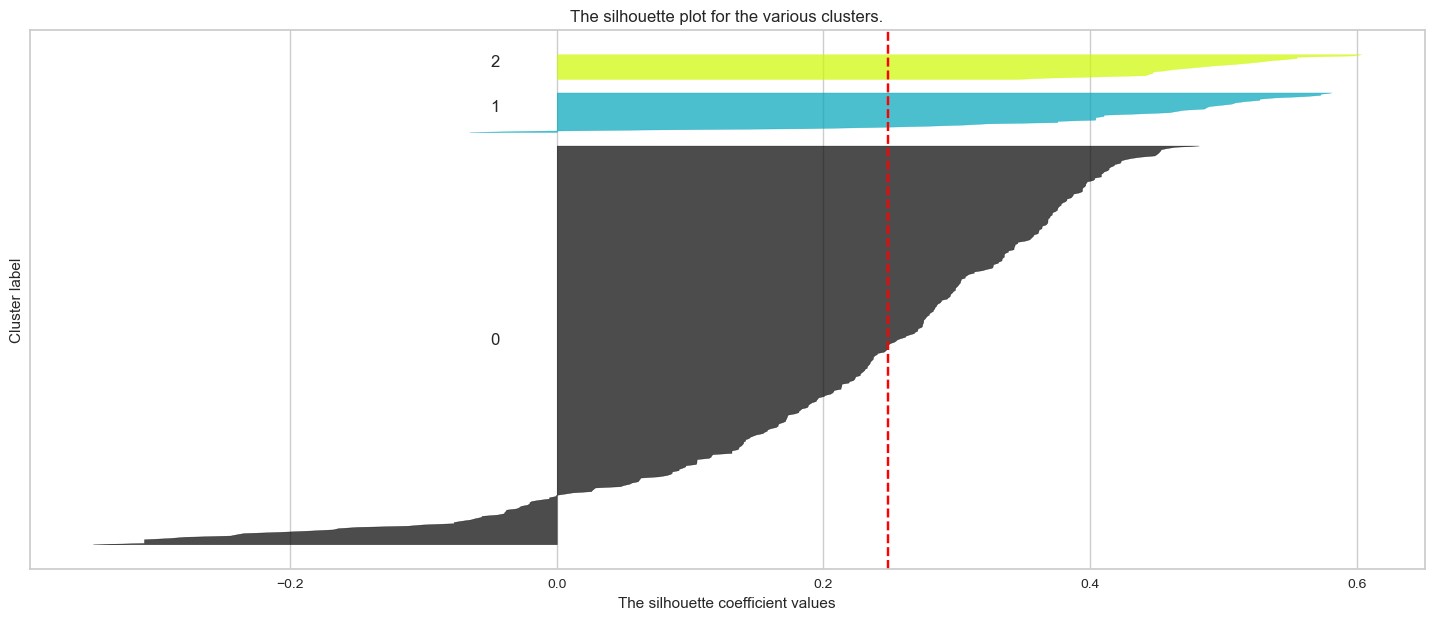

the average silhouette value is 0.2487643846235244


In [37]:
# adjust eps value to 1,min_sample to 15
db = DBSCAN(eps=1, min_samples=15)
D_cluster_labels = db.fit_predict(pca_df)

# extracted all label exclude noisy point(-1)
unique_labels = np.unique(D_cluster_labels[D_cluster_labels != -1])

# calculate average silhouette value
silhouette_avg = silhouette_score(pca_df[D_cluster_labels != -1], D_cluster_labels[D_cluster_labels != -1])

# calculate silhouette value for every sample
sample_silhouette_values = silhouette_samples(pca_df[D_cluster_labels != -1], D_cluster_labels[D_cluster_labels != -1])

fig, ax1 = plt.subplots(1)
fig.set_size_inches(18, 7)

y_lower = 10
for i in unique_labels:
    # group samples in different cluster and sort the silhouette value 
    ith_cluster_silhouette_values = sample_silhouette_values[D_cluster_labels[D_cluster_labels != -1] == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / len(unique_labels))
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # text the cluster 
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # calculate next cluster lower line
    y_lower = y_upper + 10

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# plot average silhouette
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([]) 
plt.show()
print(f"the average silhouette value is {silhouette_avg}")


#### 5.5 Final model selected

we can see the Agglomerative Clustering behave best, with 3 clusters, silhouette score is 0.25.

### 6. EDA on 3 clusters

In [156]:
df['cluster']=A_cluster_labels

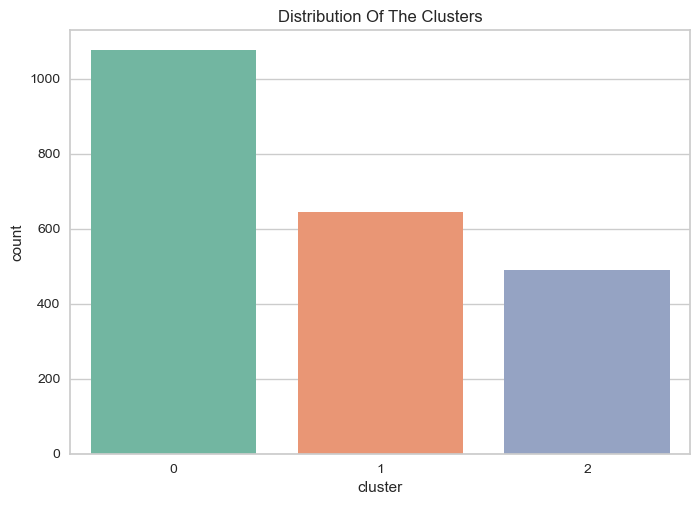

In [157]:
#Plotting countplot of clusters
pl = sns.countplot(x=df["cluster"], palette= 'Set2')
pl.set_title("Distribution Of The Clusters")
plt.show()

#### 6.1 Customer characteristics

In [110]:
df.columns

Index(['ID', 'Education', 'Marital_Status', 'Income', 'Recency', 'Wines',
       'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Age',
       'Children_num', 'Is_parents', 'Family_size', 'retain_days',
       'Total_spent', 'TotalAcceptedCmp', 'NumTotalPurchases', 'cluster'],
      dtype='object')

<Figure size 800x550 with 0 Axes>

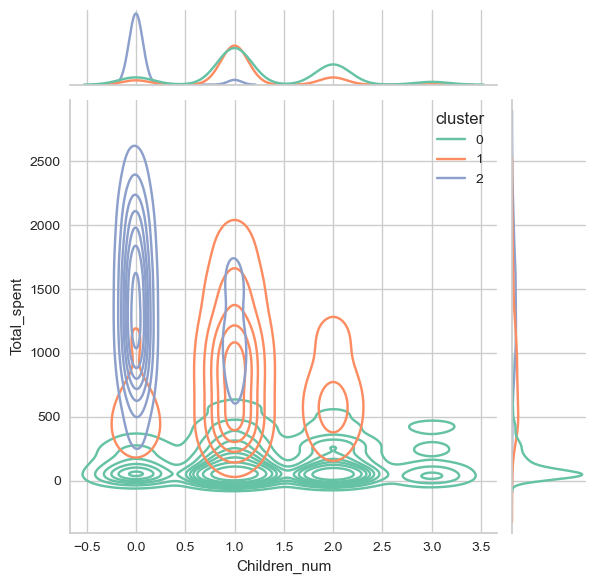

<Figure size 800x550 with 0 Axes>

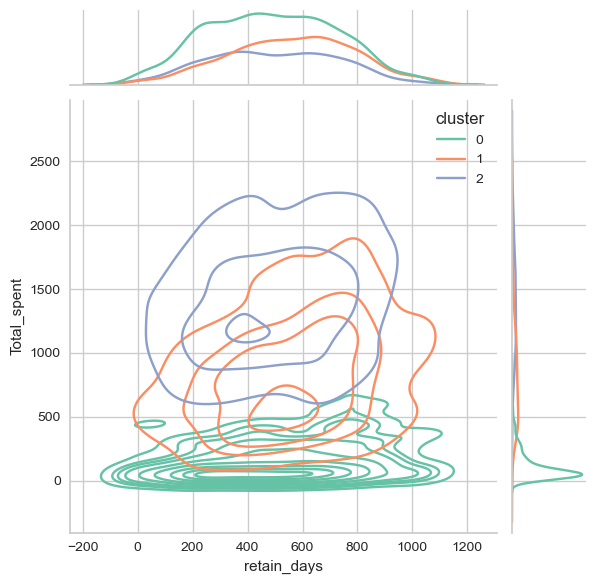

<Figure size 800x550 with 0 Axes>

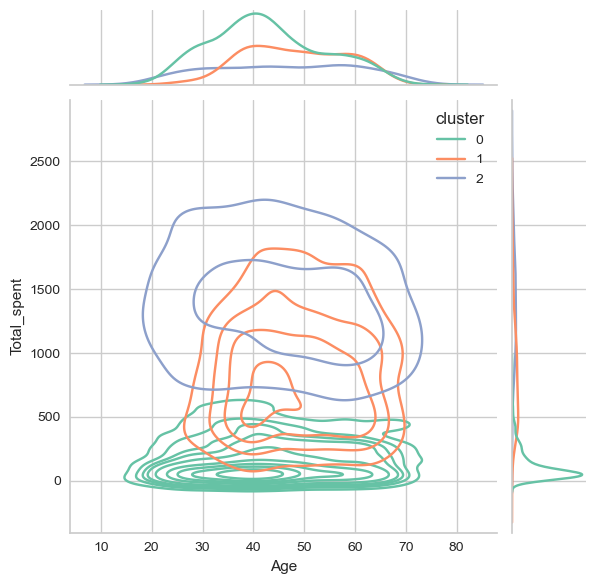

<Figure size 800x550 with 0 Axes>

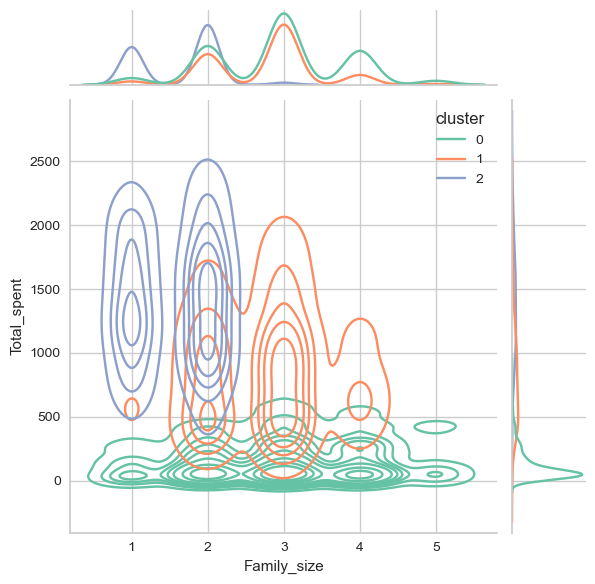

<Figure size 800x550 with 0 Axes>

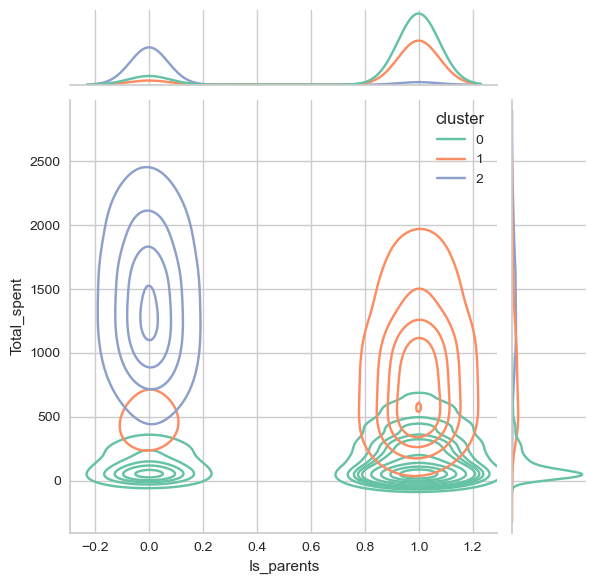

<Figure size 800x550 with 0 Axes>

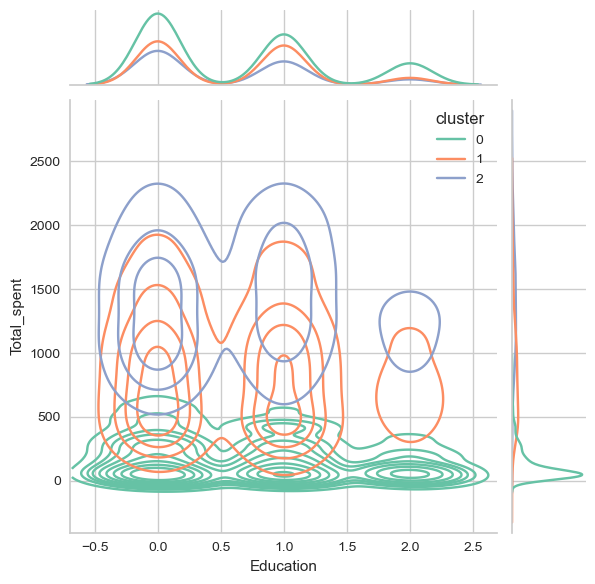

<Figure size 800x550 with 0 Axes>

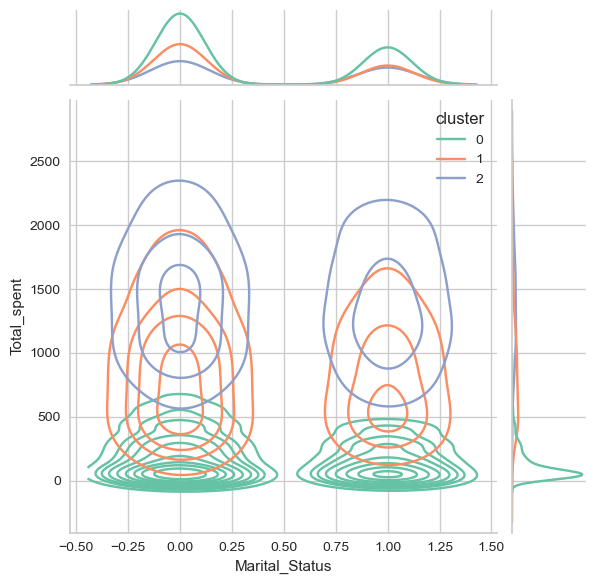

In [118]:
Personal = [ "Children_num","retain_days", "Age", "Family_size", "Is_parents", "Education","Marital_Status"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=df[i], y=df["Total_spent"], hue =df["cluster"], kind="kde", palette= 'Set2')
    plt.show()

#### 6.2 Customer Behavior

##### 6.2.1 Overview Behavior

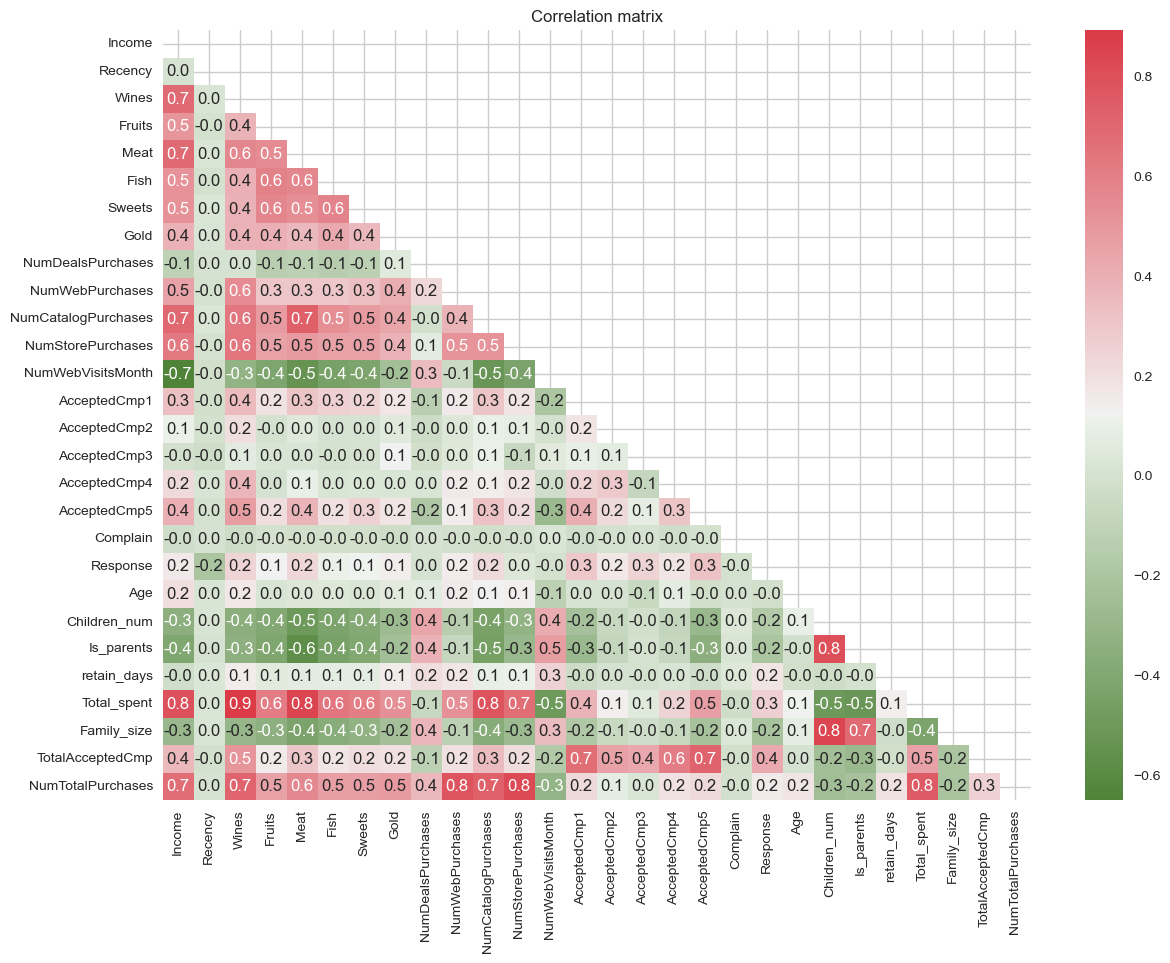

In [ ]:
#Matrix
to_corr = ['Income', 'Recency', 'Wines', 'Fruits',
       'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp1', 'AcceptedCmp2','AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5','Complain', 'Response', 'Age',
       'Children_num', 'Is_parents', 'retain_days', 'Total_spent',
       'Family_size','TotalAcceptedCmp', 'NumTotalPurchases']

cmap = sns.diverging_palette(120, 10, as_cmap=True)
matrix = np.triu(df[to_corr].corr())
plt.figure(figsize=(14, 10))
plt.title('Correlation matrix', fontsize=12)
sns.heatmap(df[to_corr].corr(), annot=True,
            fmt='.1f', cmap=cmap, mask=matrix)

plt.show()

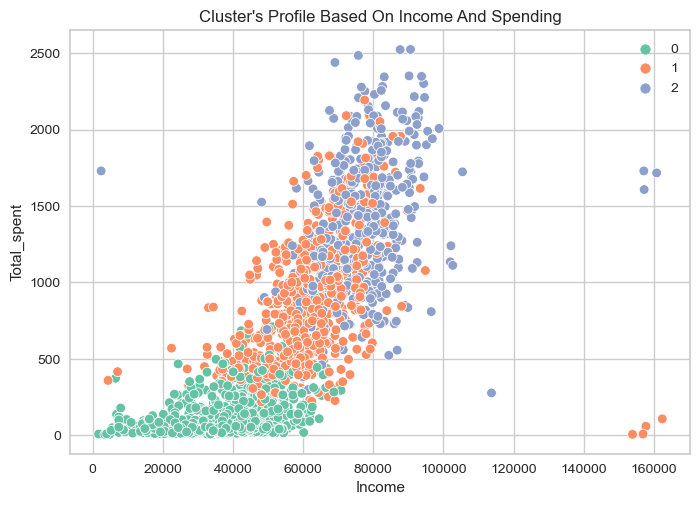

In [ ]:
#Income and spend Amount
pl = sns.scatterplot(y=df["Total_spent"], x=df["Income"],hue=df["cluster"], palette= 'Set2')
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

In [120]:
df.col

Index(['ID', 'Education', 'Marital_Status', 'Income', 'Recency', 'Wines',
       'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Age',
       'Children_num', 'Is_parents', 'Family_size', 'retain_days',
       'Total_spent', 'TotalAcceptedCmp', 'NumTotalPurchases', 'cluster'],
      dtype='object')

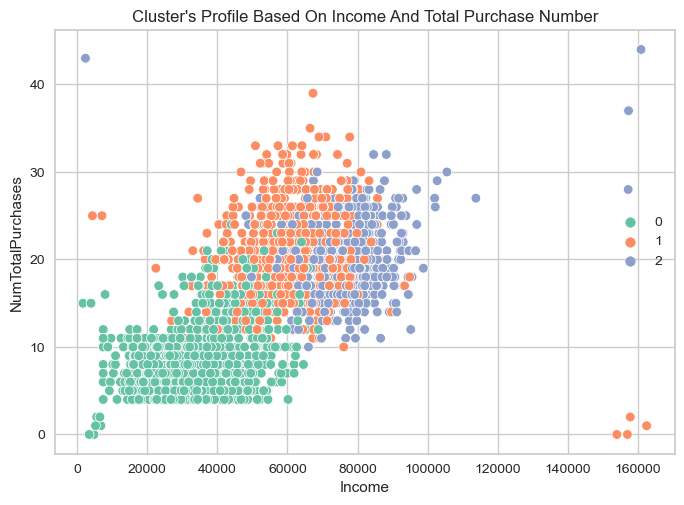

In [121]:
#Income and purchase number
pl = sns.scatterplot(y=df["NumTotalPurchases"], x=df["Income"],hue=df["cluster"], palette= 'Set2')
pl.set_title("Cluster's Profile Based On Income And Total Purchase Number")
plt.legend()
plt.show()

##### 6.2.2 Product Preference

In [122]:
df.columns

Index(['ID', 'Education', 'Marital_Status', 'Income', 'Recency', 'Wines',
       'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Age',
       'Children_num', 'Is_parents', 'Family_size', 'retain_days',
       'Total_spent', 'TotalAcceptedCmp', 'NumTotalPurchases', 'cluster'],
      dtype='object')

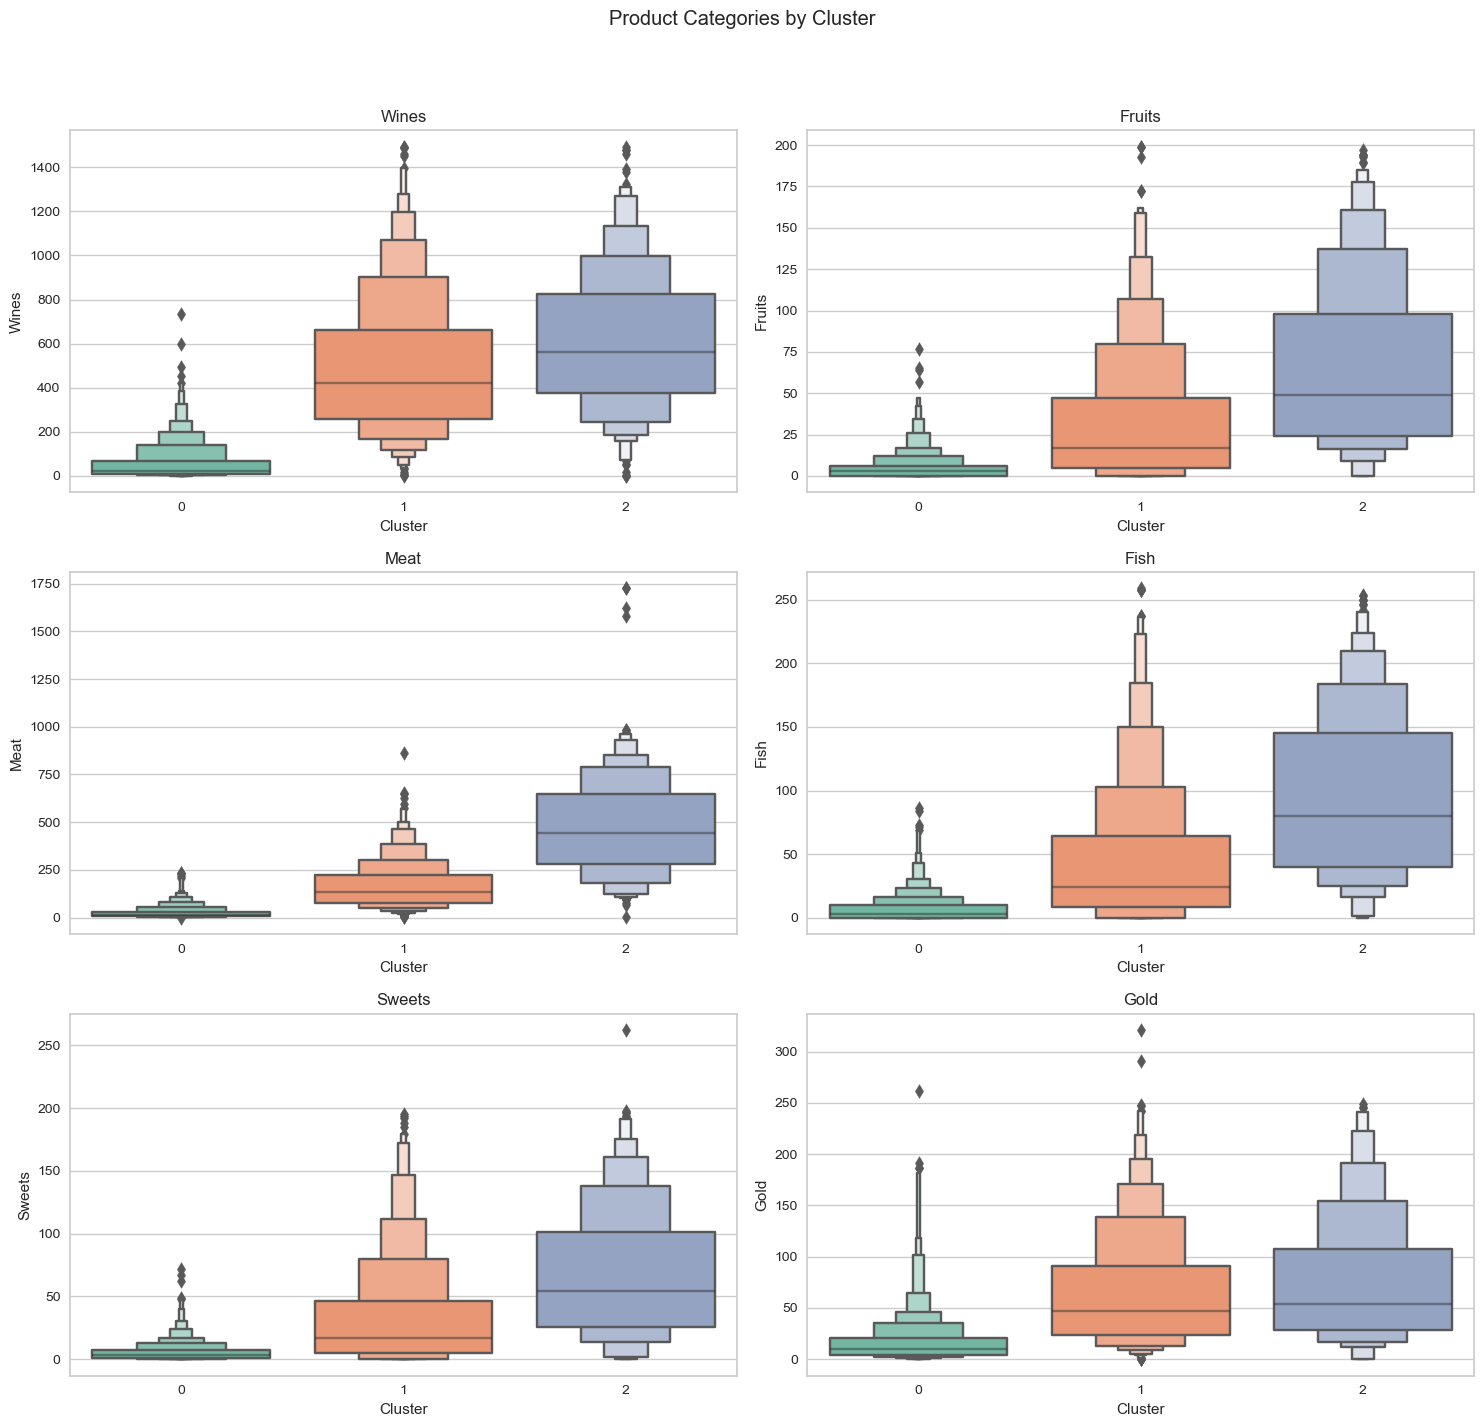

In [169]:
Product = ["Wines", "Fruits", "Meat", "Fish", "Sweets", "Gold"]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
fig.suptitle('Product Categories by Cluster')

for i, product in enumerate(Product):
    row = i // 2 
    col = i % 2 
    ax = axes[row, col]
    sns.boxenplot(y=df[product], x=df["cluster"], ax=ax, palette='Set2')
    ax.set_title(product)
    ax.set_xlabel('Cluster')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# 显示图形
plt.show()


##### 6.2.3 Purchase Channels

In [158]:
df=df.rename(columns={"NumDealsPurchases":"Deal","NumWebPurchases":"Web",'NumCatalogPurchases':"Catalog","NumStorePurchases":"Store"})

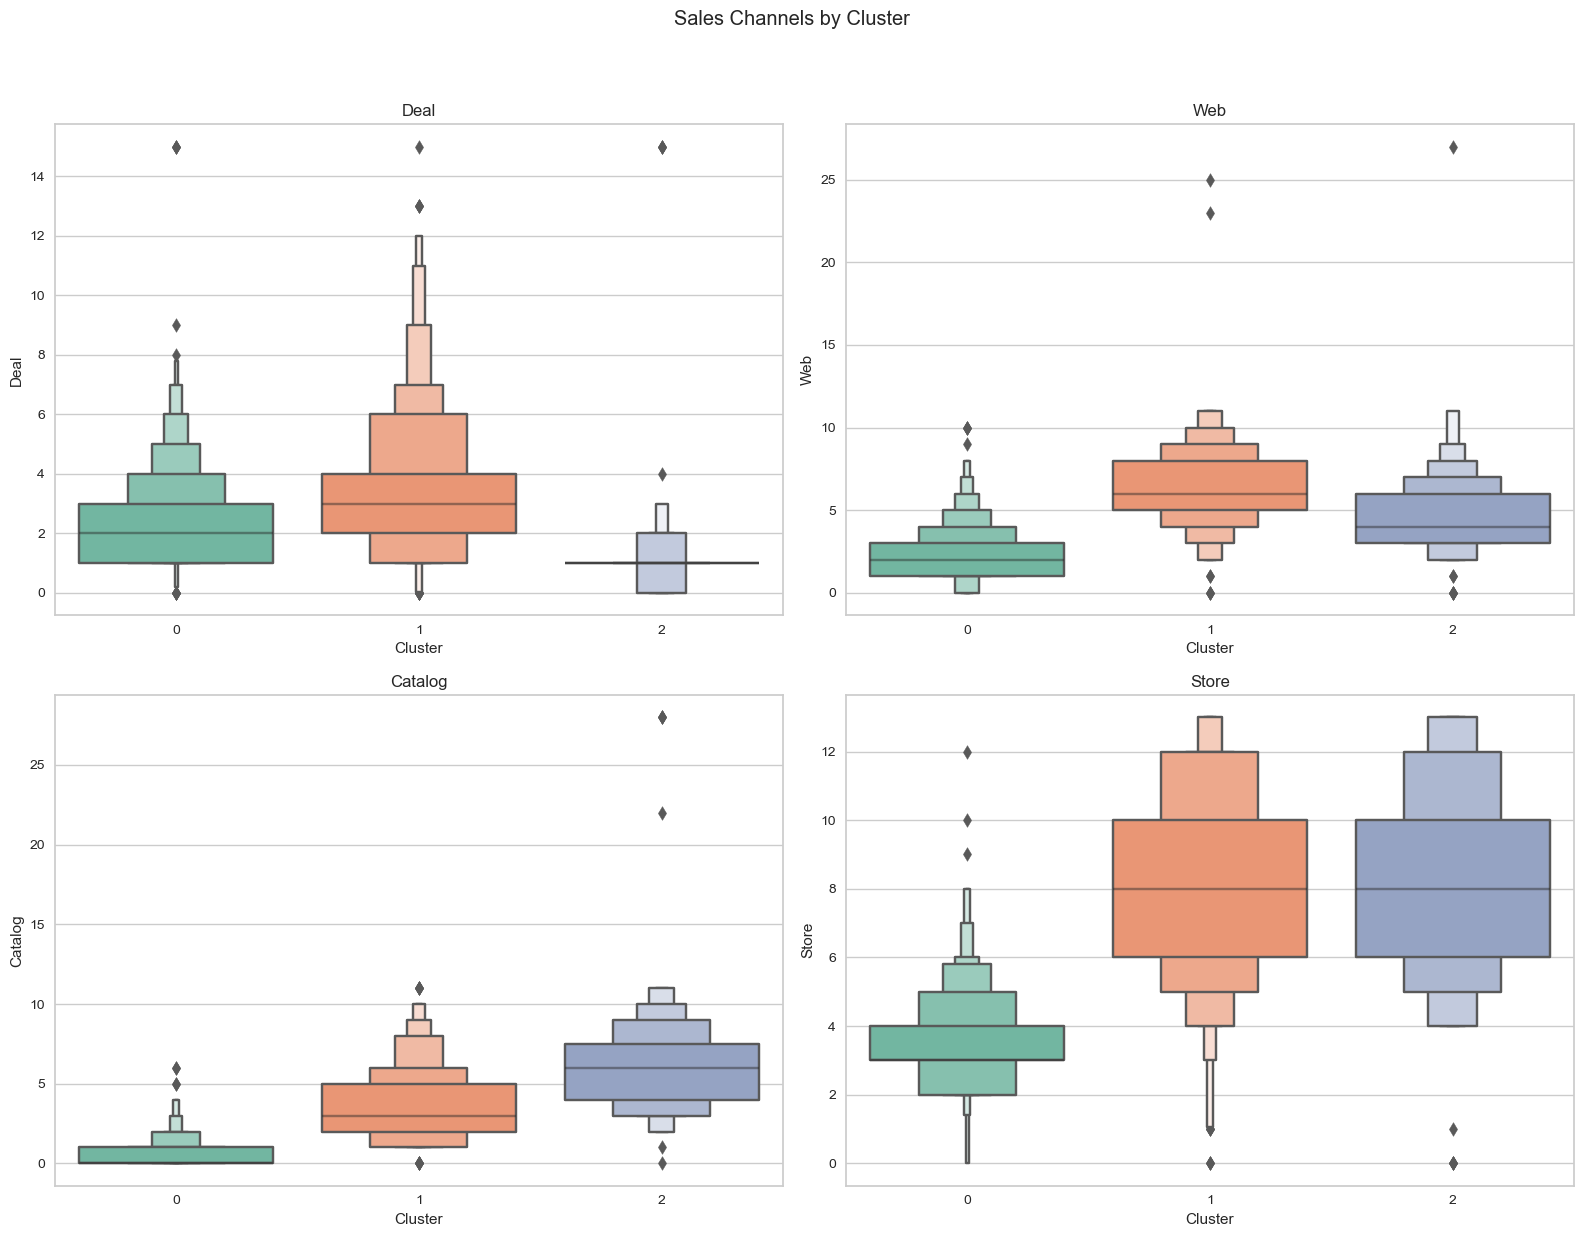

In [175]:
Channel = ["Deal", "Web", "Catalog", "Store"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 13))
fig.suptitle('Sales Channels by Cluster')

for i, channel in enumerate(Channel):
    row = i // 2 
    col = i % 2   
    ax = axes[row, col]  
    sns.boxenplot(y=df[channel], x=df["cluster"], ax=ax, palette='Set2')
    ax.set_title(channel)  
    ax.set_xlabel('Cluster')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

##### 6.2.4 Customer Activation

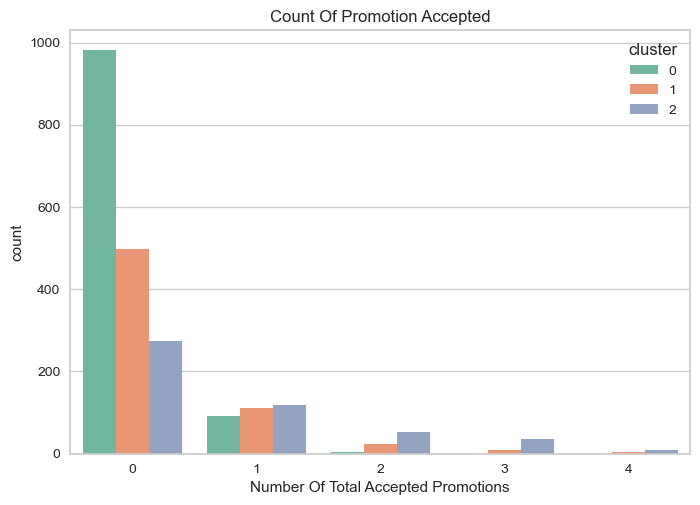

In [164]:
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=df["TotalAcceptedCmp"],hue=df["cluster"], palette= 'Set2')
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

In [166]:
df.columns

Index(['ID', 'Education', 'Marital_Status', 'Income', 'Recency', 'Wines',
       'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'Deal', 'Web', 'Catalog',
       'Store', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4',
       'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response',
       'Age', 'Children_num', 'Is_parents', 'Family_size', 'retain_days',
       'Total_spent', 'TotalAcceptedCmp', 'NumTotalPurchases', 'cluster'],
      dtype='object')

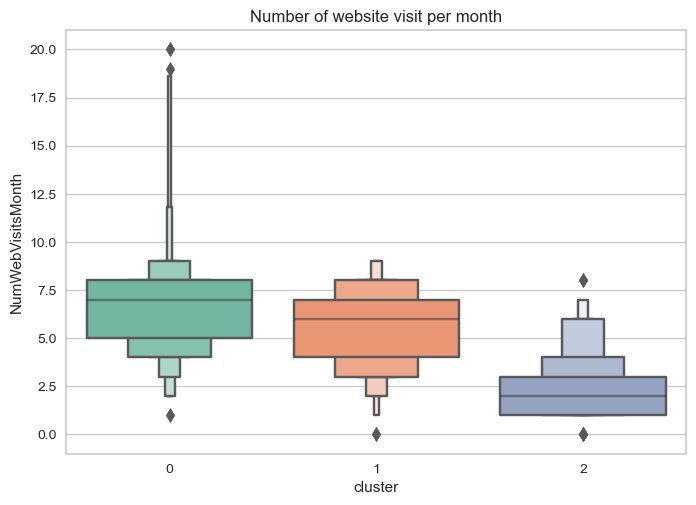

In [168]:
#Plotting the website visit per month
plt.figure()
pl=sns.boxenplot(y=df["NumWebVisitsMonth"],x=df["cluster"], palette='Set2')
pl.set_title("Number of website visit per month")
plt.show()

### 7.Customer Profile